In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time
from sklearn import metrics
import math 
from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting,ARIMA
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
import statsmodels

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

## Getting the data: 2014-2015 only

In [173]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_CA_3_2014.csv',index_col='date').fillna(0)[:-1]
data.index = data.index.astype('datetime64[ns]')
data = data.loc['2014-01-01':'2016-05-01']

data.reset_index(inplace=True)

## Some easy processing

In [174]:
#modify wday into sin and cos to get rid if hierarchy in the cat numbers

#data['sin_wday'] = data.wday.apply(math.sin)
#data['cos_wday'] = data.wday.apply(math.cos)

# transfor unique event days into bool
data['event_1'] = data.event_name_1.map({0:0}).fillna(1)
data['event_2'] = data.event_name_2.map({0:0}).fillna(1)

# still want to know the type though

data = data.join(pd.get_dummies(data.event_type_1, prefix='event_type_1'))
data = data.join(pd.get_dummies(data.event_type_2, prefix='event_type_2'))

# getting rid of irrelevant data

data = data.drop(['d','id','store_id','weekday','wday',
                  'event_name_1', 'event_name_2',
                  'event_type_1','event_type_2',
                  'year','snap_TX','snap_WI'], axis=1)

### aggregate data weekly

In [175]:
#weekly_sale_price = pd.DataFrame(data.groupby('item_id').resample('W-Mon', on='date').mean()['sell_price'])
#data = data.groupby('item_id').resample('W-Mon', on='date').sum()
#data['sale_price'] = weekly_sale_price['sell_price']

In [176]:
#data.reset_index(inplace=True)
data.head()

date        item_id  sell_price  month  snap_CA  sales  event_1  \
0 2014-01-01  HOBBIES_1_001        8.26    1.0      1.0    2.0      1.0   
1 2014-01-02  HOBBIES_1_001        8.26    1.0      1.0    1.0      0.0   
2 2014-01-03  HOBBIES_1_001        8.26    1.0      1.0    0.0      0.0   
3 2014-01-04  HOBBIES_1_001        8.26    1.0      1.0    0.0      0.0   
4 2014-01-05  HOBBIES_1_001        8.26    1.0      1.0    0.0      0.0   

   event_2  event_type_1_0  event_type_1_Cultural  event_type_1_National  \
0      0.0               0                      0                      1   
1      0.0               1                      0                      0   
2      0.0               1                      0                      0   
3      0.0               1                      0                      0   
4      0.0               1                      0                      0   

   event_type_1_Religious  event_type_1_Sporting  event_type_2_0  \
0                       0                      0               1   
1                       0                      0               1   
2                       0                      0               1   
3                       0                      0               1   
4                       0                      0               1   

   event_type_2_Cultural  event_type_2_Religious  
0                      0                       0  
1                      0                       0  
2                      0                       0  
3                      0                       0  
4                      0                       0

### Now let's pick 3 most popular items to work with them further.

We will also plot sales for the items

In [177]:
top_items = data.groupby('item_id').sum().sort_values(by='sales').index[-5:]

alt.data_transformers.disable_max_rows()

alt.Chart(data.loc[data.item_id.isin(top_items)]).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

alt.Chart(...)

In [178]:
def get_input_item(item_id='HOUSEHOLD_1_110'):
    item = data.loc[data.item_id.isin([item_id])]
    #item.loc[item.sales<=0,'sales'] = item.sales.median()
    return item

len(get_input_item(item_id='HOUSEHOLD_1_110'))

852

In [136]:
#sm.graphics.tsa.plot_pacf(get_input_item(item_id='HOUSEHOLD_1_110').sales,lags=100)

## Building prediction models

In [179]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.5, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates=None,
                             past_covariates=None,
                             model_display_name=None, 
                             past_covs = False,
                             future_covs = False):

    horizon = 1
    
    forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              past_covariates = past_covariates if past_covs else None,
                                              future_covariates = future_covariates if future_covs else None,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*2)]
    else:
        return res_df
    #return res_df

In [138]:
"""input_timeseries = TimeSeries.from_dataframe(get_input_item('HOUSEHOLD_1_110').set_index('date'), value_cols=['sales'])


val_cols = data.drop(['date', 'item_id', 'sell_price', 'sales'],axis=1).columns

external_covs = TimeSeries.from_dataframe(get_input_item('HOUSEHOLD_1_110').set_index('date'), 
                                   value_cols=val_cols)

lags = [-1,-2]
lags_future_covariates = [-1,-2]

# We first set aside the first 33% as training series:
input_train, _ = input_timeseries.split_before(0.33)

    
regr_model_lags =  RegressionModel(lags=lags)

regr_model_lags.fit(input_train)

regr_model_cov = RegressionModel(lags=lags,
                                 lags_past_covariates = lags,
                                 lags_future_covariates = lags_future_covariates)

regr_model_cov.fit(input_train,
                   future_covariates = external_covs,
                   past_covariates = external_covs)
    
models = {'Regression':[regr_model_lags,False],
            'RegressionModelCov':[regr_model_cov,True,True]
          }

    
get_historical_forecasts(models['RegressionModelCov'][0],
                         input_timeseries=input_timeseries,
                         model_display_name = 'Regression',
                         future_covariates = external_covs,
                         past_covariates = external_covs,
                         past_covs = True,
                         future_covs = True)"""

"input_timeseries = TimeSeries.from_dataframe(get_input_item('HOUSEHOLD_1_110').set_index('date'), value_cols=['sales'])\n\n\nval_cols = data.drop(['date', 'item_id', 'sell_price', 'sales'],axis=1).columns\n\nexternal_covs = TimeSeries.from_dataframe(get_input_item('HOUSEHOLD_1_110').set_index('date'), \n                                   value_cols=val_cols)\n\nlags = [-1,-2]\nlags_future_covariates = [-1,-2]\n\n# We first set aside the first 33% as training series:\ninput_train, _ = input_timeseries.split_before(0.33)\n\n    \nregr_model_lags =  RegressionModel(lags=lags)\n\nregr_model_lags.fit(input_train)\n\nregr_model_cov = RegressionModel(lags=lags,\n                                 lags_past_covariates = lags,\n                                 lags_future_covariates = lags_future_covariates)\n\nregr_model_cov.fit(input_train,\n                   future_covariates = external_covs,\n                   past_covariates = external_covs)\n    \nmodels = {'Regression':[regr_model_lags,

In [180]:
 def create_forecast_for_item(itemid, lags = [-1,-2,-52],lags_future_covariates=[0,1]):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), value_cols=['sales'])

    
    val_cols = data.drop(['date', 'item_id', 'sell_price', 'sales'],axis=1).columns
    
    external_covs = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), 
                                       value_cols=val_cols)
    
    
    # We first set aside the first 33% as training series:
    input_train, _ = input_timeseries.split_before(0.33)

    naive_model_weekly = NaiveSeasonal(K=1)
    naive_model_weekly.fit(input_train)

    regr_model_lags =  RegressionModel(lags=lags)
    regr_model_lags.fit(input_train)

    regr_model_cov = RegressionModel(lags=lags,
                                     lags_past_covariates = lags,
                                     lags_future_covariates = lags_future_covariates)
    
    regr_model_cov.fit(input_train,
                       future_covariates = external_covs,
                       past_covariates = external_covs)

    
    lgbm_model_cov = LightGBMModel(lags = lags,
                                   lags_past_covariates = lags,
                                   lags_future_covariates = lags_future_covariates,
                                   boosting_type='gbdt', 
                                   num_leaves=50, 
                                   max_depth= 10, 
                                   learning_rate=0.075, 
                                   n_estimators=500)
    
    lgbm_model_cov.fit(input_train,
                       future_covariates = external_covs,
                       past_covariates = external_covs)

    lgbm_model = LightGBMModel(lags=lags,
                               boosting_type='gbdt', 
                               num_leaves=50, 
                               max_depth= 10, 
                               learning_rate=0.075, 
                               n_estimators=500)
    
    lgbm_model.fit(input_train)
    
    rf_model = RandomForest(lags=lags,
                               max_depth= 10, 
                               n_estimators=500)
    
    rf_model.fit(input_train)
    
    rf_model_cov = RandomForest(lags=lags,
                                lags_past_covariates=lags,
                                lags_future_covariates = lags_future_covariates,
                               max_depth= 10, 
                               n_estimators=500)
    
    rf_model_cov.fit(input_train,
                     future_covariates = external_covs,
                       past_covariates = external_covs)

    theta_model =  Theta(2,
                         season_mode=SeasonalityMode.ADDITIVE)
    
    theta_model.fit(input_train)
    
    #fft_model =  FFT(nr_freqs_to_keep=7, 
    #                 required_matches=set(), 
    #                 trend='exp')

    #fft_model.fit(input_train)
    
    #arima_model = ARIMA(p=3, d=0, q=2, seasonal_order=(0, 0, 0, 0), random_state=0)
    
    #arima_model.fit(input_train)
    
    models = {'Naive weekly':[naive_model_weekly,False,False],
              'Regression':[regr_model_lags,False,False],
              #'RegressionModelCov':[regr_model_cov,True,True],
              'LGBM_cov':[lgbm_model_cov,True,True],
              'LGBM':[lgbm_model,False,False],
              'RF':[rf_model,False,False],
              'RF_cov':[rf_model_cov,True,True],
              'Theta':[theta_model,False,False],
              #'ARIMA':[arima_model,False]
             }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates = external_covs,
                                                             past_covariates = external_covs,
                                                             past_covs = models[model][1],
                                                             future_covs = models[model][2]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [181]:
#create_forecast_for_item('HOUSEHOLD_1_118',lags_by_item['HOUSEHOLD_1_118'],lags_future_covariates=[1,2])
#[i for i in range(-1,-30,-1)]

In [182]:
lags_by_item = {'HOUSEHOLD_1_118':[-1,-2,-4,-7,-14,-21,-28], 
                'HOUSEHOLD_1_110':[-1,-2,-4,-7,-14,-21,-28],
                'HOUSEHOLD_1_465':[-1,-2,-4,-7,-14,-21,-28],
               'HOUSEHOLD_1_459':[-1,-2,-4,-7,-14,-21,-28],
               'HOBBIES_1_234':[-1,-2,-4,-7,-14,-21,-28]}

optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item,lags_by_item[item],
                                                               lags_future_covariates=[1,2]) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 47.2min remaining: 70.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 47.2min remaining: 31.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 47.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 47.8min finished


In [ ]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.reset_index().set_index(['date','item_id'])['sales']
#fact.loc[:,'FOODS_3_090',:].head()

In [187]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [188]:
#optimization_df.loc[optimization_df.model=='Fact']

In [189]:
alt.Chart(optimization_df).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    tooltip=['model:N','prediction_date:T','value:Q'],
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

### Evaluation function for all item_ids

In [190]:
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        fact_index = df.loc[df.model=='Fact'].index
        
        #print(m, len(df.loc[df.model=='Fact','value']),len(df.loc[df.model==m,'value']))
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rRMSE'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    res.reset_index(inplace=True)
    res.columns = ['model','rmse','rRMSE','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df.head()

model      rmse     rRMSE          item_id
0  Naive weekly  9.165359       1.0  HOUSEHOLD_1_110
1    Regression  7.913096   0.86337  HOUSEHOLD_1_110
2      LGBM_cov   8.35305  0.911372  HOUSEHOLD_1_110
3          LGBM   8.30639  0.906281  HOUSEHOLD_1_110
4            RF  7.592716  0.828414  HOUSEHOLD_1_110

In [191]:
alt.Chart(eval_df.loc[eval_df.model!='RegressionModelCov'], title = 'RMSE for items, by model').mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

In [192]:
(eval_df.groupby(['model']).sum()[['rRMSE','rmse']]/len(lags_by_item)).reset_index()

model     rRMSE       rmse
0          Fact  0.000000   0.000000
1          LGBM  0.898923  16.579851
2      LGBM_cov  0.905860  16.526266
3  Naive weekly  1.000000  19.851622
4            RF  0.822569  15.288215
5        RF_cov  0.833372  15.363073
6    Regression  0.818048  15.083973
7         Theta  0.842270  15.273240

In [193]:
alt.Chart((eval_df.loc[eval_df.model!='RegressionModelCov'].groupby(['model']).sum()[['rRMSE','rmse']]/len(lags_by_item)).reset_index(),
         title='Average rRMSE for all items, by model').mark_bar().encode(
    x=alt.X('model:N'),
    y=alt.Y('rRMSE:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

# Optimizer

### Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.

In [194]:
items_prices = data.loc[data.item_id.isin(top_items)].set_index(['item_id','date'])['sell_price']
optimization_df.set_index(['item_id','ts'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)

optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price
optimization_df

item_id         ts  value prediction_date         model  \
0      HOUSEHOLD_1_110 2014-03-02   35.0      2014-03-02  Naive weekly   
1      HOUSEHOLD_1_110 2014-03-03   33.0      2014-03-03  Naive weekly   
2      HOUSEHOLD_1_110 2014-03-04   27.0      2014-03-04  Naive weekly   
3      HOUSEHOLD_1_110 2014-03-05   25.0      2014-03-05  Naive weekly   
4      HOUSEHOLD_1_110 2014-03-06   23.0      2014-03-06  Naive weekly   
...                ...        ...    ...             ...           ...   
31595    HOBBIES_1_234 2016-04-25    0.0      2016-04-25          Fact   
31596    HOBBIES_1_234 2016-04-26    0.0      2016-04-26          Fact   
31597    HOBBIES_1_234 2016-04-27    0.0      2016-04-27          Fact   
31598    HOBBIES_1_234 2016-04-28    0.0      2016-04-28          Fact   
31599    HOBBIES_1_234 2016-04-29    0.0      2016-04-29          Fact   

       sell_price  daily_revenue  
0             3.5          122.5  
1             3.5          115.5  
2             3.5           94.5  
3             3.5           87.5  
4             3.5           80.5  
...           ...            ...  
31595         0.3            0.0  
31596         0.3            0.0  
31597         0.3            0.0  
31598         0.3            0.0  
31599         0.3            0.0  

[31600 rows x 7 columns]

In [195]:
#weekly_revenue_bl = optimization_df.groupby(['model','prediction_date']).sum().daily_revenue.reset_index()
weekly_revenue_bl = optimization_df.pivot_table(columns='model',index='prediction_date', values='daily_revenue', aggfunc='sum')

In [196]:
alt.Chart(weekly_revenue_bl).transform_fold(
    weekly_revenue_bl.columns.values,
    #['Fact'],
    as_=['Model', 'Measurement']
).mark_bar(
    opacity=0.5,
    binSpacing=0
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Model:N')
    )

alt.Chart(...)

### Optimization target:
* Every week we make predictions for each item and calculate total profit for the week
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 40% of it's final price
* We implement a discounts for each induvidual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount

* Some limitations: 
 * Amount of discount shouldn't be more than 60% (otherwise we are selling the item with loss)
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [197]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 1
        self.DECISION_TIMESTEP = 1
        self.MAX_CAPACITY = (data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        #self.BASIC_PRICES = items_prices
        #self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits):
        
        capacity_penalty = 1
        #w3_discount_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.candidate['sell_price']*(solution)/self.candidate['sell_price']
        self.candidate['sell_price_w_disount'] = self.candidate['sell_price']*(1 - solution)
        
        self.candidate['value_increase'] = pd.DataFrame(index=self.candidate['sell_price'].index, 
                                                        data=solution*3,
                                                        columns=['value_increase']) #2% increase in sales for each 1% increase in discount
        

        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*.4)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*.4)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast 

        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data['prediction_date'].unique()

        recommendation = pd.DataFrame()
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=1000)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [198]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [199]:
optimization_df.model.unique()

array(['Naive weekly', 'Regression', 'LGBM_cov', 'LGBM', 'RF', 'RF_cov',
       'Theta', 'Fact'], dtype=object)

In [119]:
#odm.calculate_optimal_decision('Naive weekly')

In [200]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 102.2min
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed: 102.2min remaining: 306.7min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed: 102.3min remaining: 170.4min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 102.7min remaining: 102.7min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed: 102.7min remaining: 61.6min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 103.3min remaining: 34.4min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 105.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 105.9min finished


In [ ]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

## Evaluation of optimization based on Fact values

In [ ]:
result_df.to_csv('ecomm_opt_result_CA_3_2015.csv')

In [ ]:
result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*.4)

## Inventory:
 * After predicting the demand N with discount we'll buy 1.1*N items. If in reality the demand is higher - that's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (40%) is being deducted from the final profit

In [ ]:
#result_weekly = result_df.groupby(['item_id','model','prediction_date']).sum()
#result_weekly[['sell_price','disount','sell_price_w_disount','value_increase']] = result_df.groupby(['item_id','model','prediction_date']).max()[['sell_price','disount','sell_price_w_disount','value_increase']]
result_df['inventory_left'] = 1.1*result_df['value_w_disount'] - result_df['value_w_disount_fact'] 
result_df['final_profit_w_discount'] = result_df['daily_profit_w_disount_fact']
result_df['final_profit_base_price'] = result_df['daily_profit_fact']


# if inventory_left>0 substract 40% of it's price from profits
result_df.loc[result_df.inventory_left>0,'final_profit_w_discount']  = result_df.loc[result_df.inventory_left>0,'daily_profit_w_disount_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*.4
result_df.loc[result_df.inventory_left>0,'final_profit_base_price']  = result_df.loc[result_df.inventory_left>0,'daily_profit_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*.4

# if inventory_lef<0 substract all additional items that we weren't able to sell
result_df.loc[result_df.inventory_left<0,'final_profit_w_discount'] = result_df.loc[result_df.inventory_left<0,'daily_profit_w_disount_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price_w_disount']
result_df.loc[result_df.inventory_left<0,'final_profit_base_price'] = result_df.loc[result_df.inventory_left<0,'daily_profit_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price']

result_df.head()

In [ ]:
#cumsum for this model

alt.data_transformers.disable_max_rows()

alt.Chart(result_df.reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('final_profit_w_discount:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

In [ ]:
"""alt.Chart(result_df.loc[:,['Fact','LGBM_cov'],:].reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()"""

In [ ]:
discounts_freq = result_df.reset_index().groupby(['model','disount']).count()['item_id'].reset_index()

alt.Chart(discounts_freq).mark_bar().encode(
    x='model:N',
    y=alt.Y('item_id:Q'),
    color=alt.Color('model:N'),
    #row='model:N',
    column='disount:N'
).properties(width=80, height=400)#.interactive()

In [ ]:
result_df

In [ ]:
eval_df.set_index(['model','item_id'], inplace=True)
eval_df['profit_increase_%'] = (result_df.groupby(['model','item_id']).sum()['final_profit_w_discount'] \
                                - result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']) \
                                /result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']
eval_df.reset_index(inplace=True)

In [87]:
alt.Chart(eval_df, title='').mark_circle().encode(
    x=alt.X('rRMSE:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
    column=alt.Column('item_id:N', title=""),
    tooltip = 'model:N'
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

## Evaluation for all items in total

In [88]:
all_items_eval = result_df.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.final_profit_w_discount - all_items_eval.loc['Fact','final_profit_base_price'])/all_items_eval.loc['Fact','final_profit_base_price']
all_items_eval['disount'] = result_df.groupby('model').mean()['disount']

<AxesSubplot:ylabel='Frequency'>

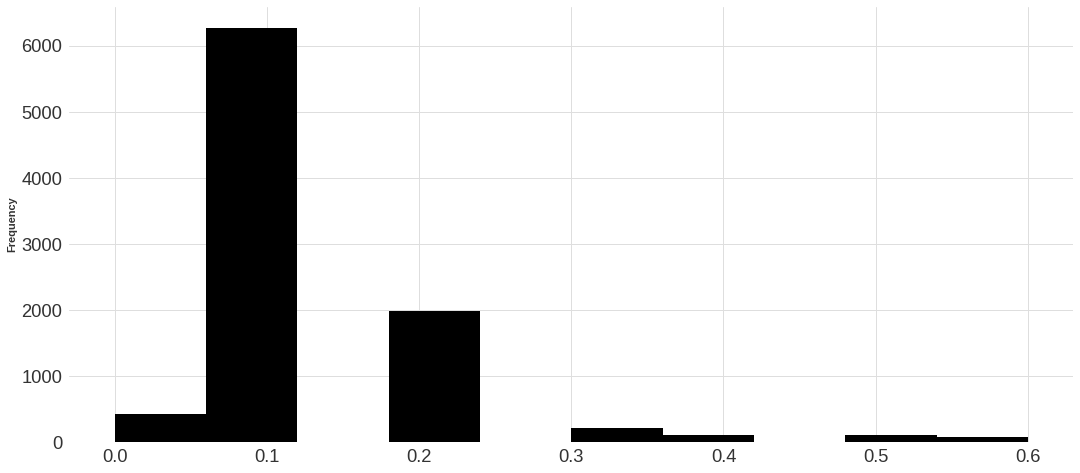

In [89]:
result_df['disount'].plot.hist()

In [90]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=True),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

In [91]:
eval_df[['rmse','rRMSE']] = eval_df[['rmse','rRMSE']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rRMSE']] = eval_df.groupby('model').mean()[['rmse','rRMSE']]

In [92]:
all_items_eval

value  sell_price  daily_revenue   disount  \
model                                                             
Fact          38052.000000     2168.25   48172.240000  0.140654   
LGBM          39374.663625     2168.25   49809.053371  0.136078   
Naive weekly  39507.000000     2168.25   49487.090000  0.132484   
RF            40699.808748     2168.25   51148.947536  0.127059   
Regression    39231.814511     2168.25   50299.697174  0.134967   
Theta         39601.669030     2168.25   50303.050476  0.131176   

              sell_price_w_disount  value_increase  value_w_disount  \
model                                                                 
Fact                      1876.711           645.6     52989.000000   
LGBM                      1884.023           624.6     55155.413668   
Naive weekly              1890.327           608.1     55113.600000   
RF                        1894.879           583.2     56265.717184   
Regression                1881.609           619.5     55120.861758   
Theta                     1884.793           602.1     55165.023945   

              daily_revenue_w_disount  daily_profit  daily_profit_w_disount  \
model                                                                         
Fact                     57299.723900  28903.344000            30530.301100   
LGBM                     59352.597089  29885.432022            31645.716526   
Naive weekly             58750.606100  29692.254000            31426.719300   
RF                       60770.891010  30689.368522            32598.919348   
Regression               59866.134640  30179.818304            31781.859714   
Theta                    59921.818446  30181.830285            31934.853011   

              value_fact  daily_profit_fact  value_w_disount_fact  \
model                                                               
Fact             38052.0          28903.344               52989.0   
LGBM             38052.0          28903.344               53529.3   
Naive weekly     38052.0          28903.344               53784.6   
RF               38052.0          28903.344               52297.5   
Regression       38052.0          28903.344               53844.6   
Theta            38052.0          28903.344               52989.3   

              daily_profit_w_disount_fact  inventory_left  \
model                                                       
Fact                           30530.3011     5298.900000   
LGBM                           30610.2749     7141.655035   
Naive weekly                   30511.6526     6840.360000   
RF                             30711.8925     9594.788902   
Regression                     30328.1007     6788.347934   
Theta                          30589.3968     7692.226339   

              final_profit_w_discount  final_profit_base_price  \
model                                                            
Fact                     27853.358820             26226.401720   
LGBM                     15096.048948             11974.176682   
Naive weekly             12665.362400              9267.207000   
RF                       16765.634543             13957.381293   
Regression               17034.186892             14366.136500   
Theta                    16492.772870             13727.205060   

              profit_increase_%       rmse     rRMSE  
model                                                 
Fact                   0.062035   0.000000  0.000000  
LGBM                  -0.424395  18.250000  0.905273  
Naive weekly          -0.517076  22.328125  1.000000  
RF                    -0.360734  17.156250  0.841309  
Regression            -0.350495  16.343750  0.802246  
Theta                 -0.371139  17.171875  0.843262

In [93]:
chart = alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('rRMSE:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'y': [all_items_eval.loc['Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='y')

chart + chart.transform_loess('rRMSE:Q', 'profit_increase_%:Q', bandwidth=.99).mark_line()

alt.LayerChart(...)

In [94]:
alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('disount:Q',axis=alt.Axis(format='%')),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

alt.Chart(...)

In [95]:
all_items_eval

value  sell_price  daily_revenue   disount  \
model                                                             
Fact          38052.000000     2168.25   48172.240000  0.140654   
LGBM          39374.663625     2168.25   49809.053371  0.136078   
Naive weekly  39507.000000     2168.25   49487.090000  0.132484   
RF            40699.808748     2168.25   51148.947536  0.127059   
Regression    39231.814511     2168.25   50299.697174  0.134967   
Theta         39601.669030     2168.25   50303.050476  0.131176   

              sell_price_w_disount  value_increase  value_w_disount  \
model                                                                 
Fact                      1876.711           645.6     52989.000000   
LGBM                      1884.023           624.6     55155.413668   
Naive weekly              1890.327           608.1     55113.600000   
RF                        1894.879           583.2     56265.717184   
Regression                1881.609           619.5     55120.861758   
Theta                     1884.793           602.1     55165.023945   

              daily_revenue_w_disount  daily_profit  daily_profit_w_disount  \
model                                                                         
Fact                     57299.723900  28903.344000            30530.301100   
LGBM                     59352.597089  29885.432022            31645.716526   
Naive weekly             58750.606100  29692.254000            31426.719300   
RF                       60770.891010  30689.368522            32598.919348   
Regression               59866.134640  30179.818304            31781.859714   
Theta                    59921.818446  30181.830285            31934.853011   

              value_fact  daily_profit_fact  value_w_disount_fact  \
model                                                               
Fact             38052.0          28903.344               52989.0   
LGBM             38052.0          28903.344               53529.3   
Naive weekly     38052.0          28903.344               53784.6   
RF               38052.0          28903.344               52297.5   
Regression       38052.0          28903.344               53844.6   
Theta            38052.0          28903.344               52989.3   

              daily_profit_w_disount_fact  inventory_left  \
model                                                       
Fact                           30530.3011     5298.900000   
LGBM                           30610.2749     7141.655035   
Naive weekly                   30511.6526     6840.360000   
RF                             30711.8925     9594.788902   
Regression                     30328.1007     6788.347934   
Theta                          30589.3968     7692.226339   

              final_profit_w_discount  final_profit_base_price  \
model                                                            
Fact                     27853.358820             26226.401720   
LGBM                     15096.048948             11974.176682   
Naive weekly             12665.362400              9267.207000   
RF                       16765.634543             13957.381293   
Regression               17034.186892             14366.136500   
Theta                    16492.772870             13727.205060   

              profit_increase_%       rmse     rRMSE  
model                                                 
Fact                   0.062035   0.000000  0.000000  
LGBM                  -0.424395  18.250000  0.905273  
Naive weekly          -0.517076  22.328125  1.000000  
RF                    -0.360734  17.156250  0.841309  
Regression            -0.350495  16.343750  0.802246  
Theta                 -0.371139  17.171875  0.843262